In this project, I will examine the Matrix Factorization method to predict users ratings for movies. 
I use MovieLens data from https://grouplens.org/datasets/movielens/1m/

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras import layers
from keras import ops

Reading Data

In [3]:
ratings = pd.read_csv(
    "Data/ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
    encoding="ISO-8859-1",
    engine="python",
)

movies = pd.read_csv(
    "Data/ml-1m/movies.dat",
    sep="::",
    names=["movie_id", "title", "genres"],
    encoding="ISO-8859-1",
    engine="python",
)

Exploring ratings

In [4]:
ratings.head(n=1)

,user_id,movie_id,rating,unix_timestamp
0,1,1193,5,978300760


In [5]:
del ratings['unix_timestamp']
ratings['rating'] = ratings['rating'].astype('float32')

num_users = ratings['user_id'].nunique()
num_rated_movies = ratings['movie_id'].nunique()
sparsity = np.round(1. - len(ratings)/(num_users * num_rated_movies),3)
rating_values = np.sort(ratings['rating'].unique())

print('number of users: ', num_users)
print('number of rated movies: ', num_rated_movies)
print('sparsity of rating data: ', sparsity)
print('rating values: ', rating_values)

number of users:  6040
number of rated movies:  3706
sparsity of rating data:  0.955
rating values:  [1. 2. 3. 4. 5.]


Some Statistics ...

In [6]:
data_stats = ratings.copy()
# user statistics
data_stats['user_num_rating'] = data_stats.groupby('user_id')['rating'].transform('count').astype('int')
min_user_num_rating, max_user_num_rating = data_stats['user_num_rating'].min(), data_stats['user_num_rating'].max()
data_stats['user_average_rating'] = data_stats.groupby('user_id')['rating'].transform('mean').round(3)
min_user_average_rating, max_user_average_rating = data_stats['user_average_rating'].min(), data_stats['user_average_rating'].max()
# movie statistics
data_stats['movie_num_rating'] = data_stats.groupby('movie_id')['rating'].transform('count').astype('int')
min_movie_num_rating, max_movie_num_rating = data_stats['movie_num_rating'].min(), data_stats['movie_num_rating'].max()
data_stats['movie_average_rating'] = data_stats.groupby('movie_id')['rating'].transform('mean').round(3)
min_movie_average_rating, max_movie_average_rating = data_stats['movie_average_rating'].min(), data_stats['movie_average_rating'].max()

print(f'users contribution to rating are in range ({min_user_num_rating}, {max_user_num_rating})')
print(f'users average rating are in the range ({min_user_average_rating:.3f}, {max_user_average_rating:.3f})')
print(f'number of ratings for a movie ranges in ({min_movie_num_rating}, {max_movie_num_rating})')
print(f'average ratings for a movie ranges in ({min_movie_average_rating}, {max_movie_average_rating}) ')

users contribution to rating are in range (20, 2314)
users average rating are in the range (1.015, 4.963)
number of ratings for a movie ranges in (1, 3428)
average ratings for a movie ranges in (1.0, 5.0) 


In [7]:
data_stats.head(n=1)

,user_id,movie_id,rating,user_num_rating,user_average_rating,movie_num_rating,movie_average_rating
0,1,1193,5.0,53,4.189,1725,4.391


Exploring movies

In [8]:
movies.head(n=1)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy


In [9]:
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)', expand=False).astype('int')

a = data_stats.loc[:,['movie_id','movie_num_rating','movie_average_rating']].drop_duplicates()
movies = movies.join(a.set_index('movie_id'), on='movie_id')
movies.fillna(0, inplace=True)

num_movies = movies['movie_id'].nunique()

print('number of movies: ', num_movies)
print(f'movies are released between years {movies.year.min()} and {movies.year.max()}')

number of movies:  3883
movies are released between years 1919 and 2000


Make Train/Test Splits

In [10]:
data_stats = data_stats.sample(frac=1)
x = data_stats[['user_id','movie_id']].values
y = data_stats['rating']

index = int(0.9 * len(data_stats))
x_train, y_train, x_test, y_test = x[:index], y[:index], x[index:], y[index:]

Base Model

We assume that the base prediction for rating of movies in the test dataset equals the average rating of those movies. 

In [11]:
base_prediction = data_stats['movie_average_rating'][index:]
base_error = np.sqrt(MeanSquaredError()(y_test, base_prediction))
print('base error: ',base_error.round(3))

base error:  0.976


Matrix Factorization Model

In [12]:
embedding_size = int(np.sqrt(min(num_users, num_movies)))
print('embedding size = ',embedding_size)

embedding size =  62


In [13]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-3),
            name = 'user_embedding',
        )
        self.user_bias = layers.Embedding(num_users, 1, name='user_bias')
        
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-3),
            name = 'movie_embedding' 
        )
        self.movie_bias = layers.Embedding(num_movies, 1, name = 'movie_bias')

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = ops.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias
        x = ops.nn.sigmoid(x) * 5.5
        return x

In [14]:
model = RecommenderNet(num_users, num_movies, embedding_size)
model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate=0.001))
model.fit(x=x_train, y=y_train, batch_size=64, epochs=5, verbose=0, validation_data=(x_test, y_test))

Matrix factorization model hase decreased the test error by ~7%.

In [15]:
MF_prediction = model.predict(x_test)
MF_error = np.sqrt(MeanSquaredError()(y_test, MF_prediction.flatten()))
print(f'Matrix Factorization error: {MF_error:.2f}' )

relative_error_reduction = (base_error - MF_error) / base_error * 100
print(f'relative error reduction: {relative_error_reduction:.1f}%')

3126/3126 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Matrix Factorization error: 0.91
relative error reduction: 6.9%


Getting Trained Movie Embedding

Movies are represented as 62+1 dimensional vectors in the space of latent factors. 

In [16]:
trained_movie_embedding = model.get_layer('movie_embedding').get_weights()[0]
trained_movie_bias = model.get_layer('movie_bias').get_weights()[0]
movie_vectors = np.concatenate([trained_movie_embedding,trained_movie_bias], axis=1)

We project movie vectors into a 2-dim space using PCA method to visualize the principle components that describe movies. 

In [17]:
pca = PCA(n_components=2)
projected_movie_vectors = pca.fit_transform(movie_vectors)

explained_variance_ratio = pca.explained_variance_ratio_
print(f'explianed variance ratios by principle components are [{explained_variance_ratio[0]:.3f}, {explained_variance_ratio[1]:.3f}]')

explianed variance ratios by principle components are [0.984, 0.002]


Movie vectors are almost completely determined by the first principle component which explains ~98% of variance in data. 

The first principle component of movie vectors has perfect anti-correlation with bias. Thus, movies are completely determined by bias factor.

In [18]:
movies['bias'] = trained_movie_bias
movies['pc1'] = projected_movie_vectors[:,0]

corr=movies[['bias','pc1']].corr()
bias_pc1_correlation = corr.loc['bias']['pc1']
print(f'correlation between bias factor and the first principle component of movie vectors is {bias_pc1_correlation:.1f}')

del movies['pc1']

correlation between bias factor and the first principle component of movie vectors is -1.0


More on Bias Factor ...

Movies with the same average rating may have different rating distributions. Movies with a positive bias have sharp peaks indicating there is a general agreement on their rating, while movies with a negative bias have shallow distribution over the rating range implying there is no consensus on their rating. Our simple matrix factorization model has basically classified movies based on the fact that how much the population agree on movies rating.

The following movies are examples of movies with almost the same average rating and oposite biases. For the positive bias movie, there are more people who agree upon the rating.

In [19]:
movies[(movies.movie_id==223) | (movies.movie_id==1270)]

,movie_id,title,genres,year,movie_num_rating,movie_average_rating,bias
220,223,Clerks (1994),Comedy,1994,1412.0,3.947,-0.942944
1250,1270,Back to the Future (1985),Comedy|Sci-Fi,1985,2583.0,3.990,1.213277


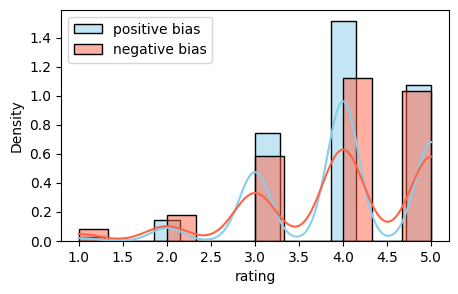

In [20]:
positive_bias = ratings[ratings.movie_id==1270]
negative_bias = ratings[ratings.movie_id==223]

plt.figure(figsize=(5,3))
sns.histplot(positive_bias['rating'], kde=True, stat='density', label='positive bias', color='skyblue')
sns.histplot(negative_bias['rating'], kde=True, stat='density', label='negative bias', color='tomato')
plt.legend()
plt.show()

Movies with higher number of ratings have a greater chance to get trained more accurately.  

In [21]:
top_movies = movies.sort_values(by='movie_num_rating', ascending=False).head(n=1000)

There is a positive correlation between bias and average rating of movies. The reason is that people who agree on small ratings (positive bias and small average rating) usually do not provide ratings. 

correlation between bias factor and movie average rating is 0.16


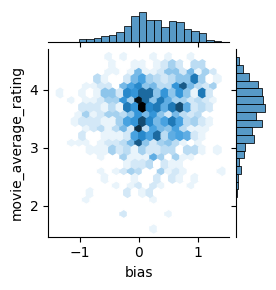

In [22]:
corr=top_movies[['bias','movie_average_rating']].corr()
bias_average_correlation = corr.loc['bias']['movie_average_rating']
print(f'correlation between bias factor and movie average rating is {bias_average_correlation:.2f}')

sns.jointplot(x='bias', y='movie_average_rating', data=top_movies, kind='hex', height=3)
plt.show()

Popular Movies

There is a strong consesus on rating for movies with high positive bias. The following plot gives the most popular movies in the list. 

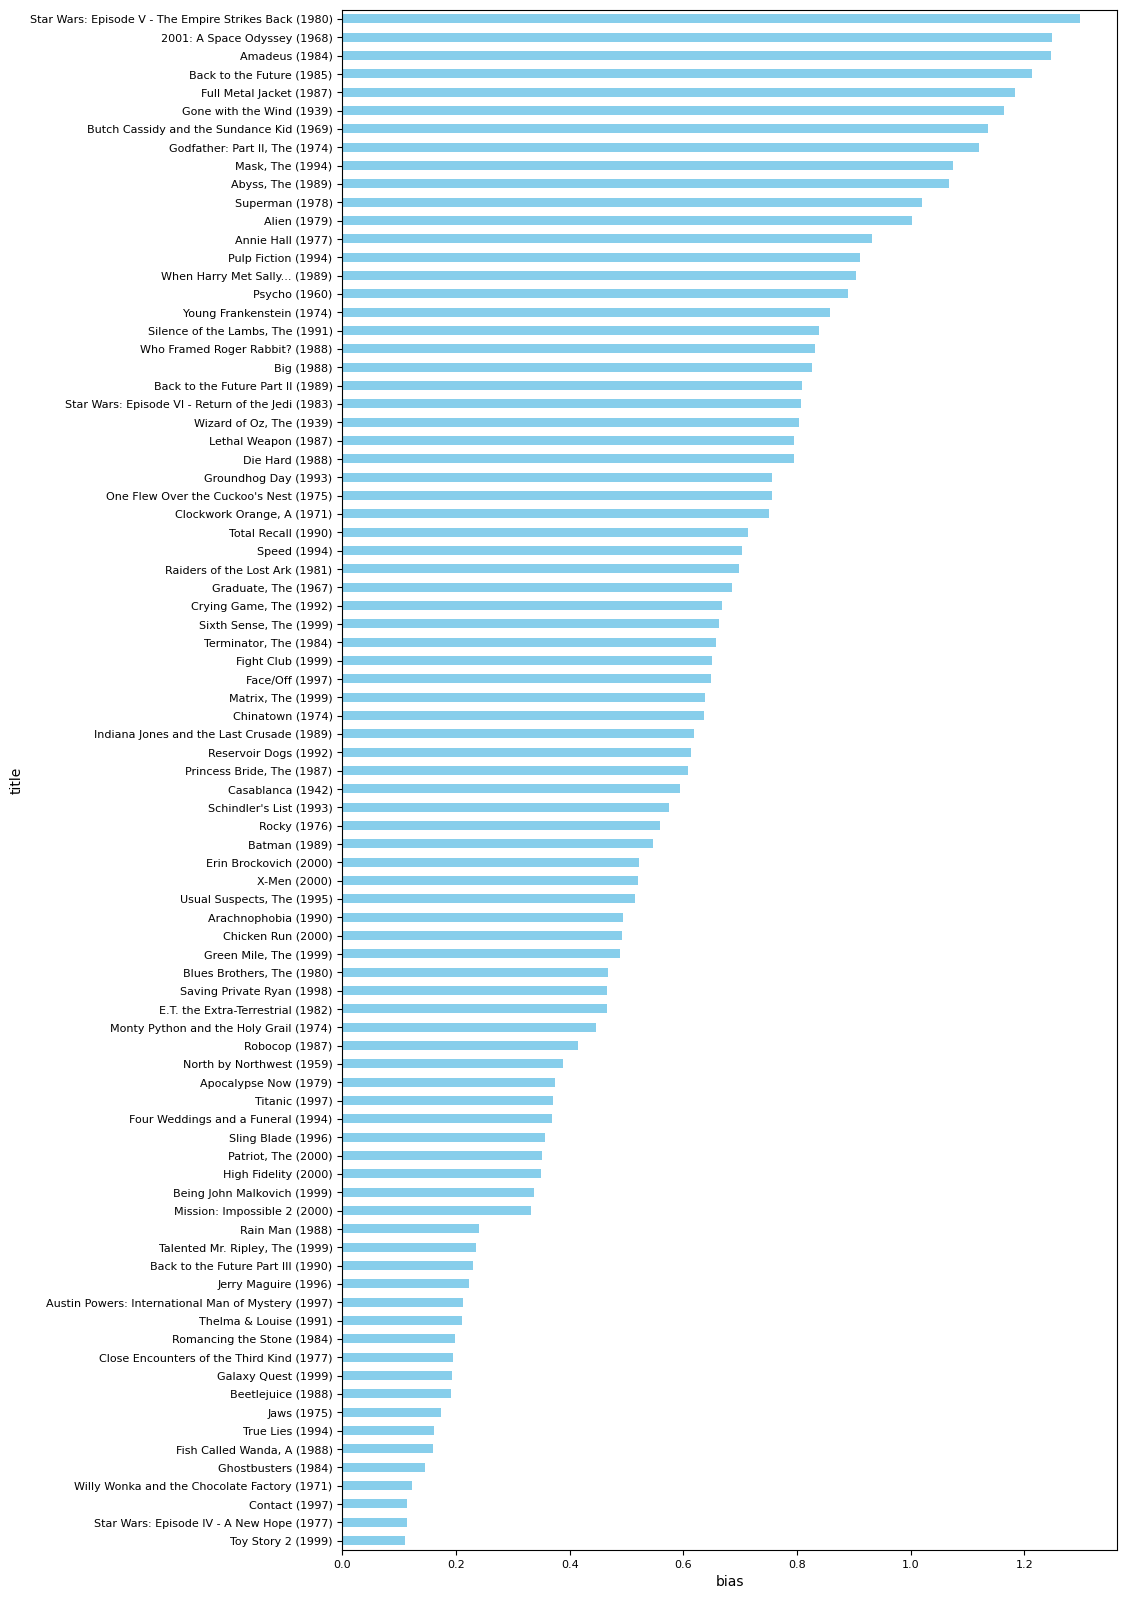

In [23]:
positive_bias_movies = top_movies.head(n=150)
positive_bias_movies = positive_bias_movies[positive_bias_movies.bias>0.1]
positive_bias_movies = positive_bias_movies.sort_values(by='bias')
positive_bias_movies.plot(kind='barh', x='title', y='bias', color='skyblue', legend=False, fontsize=8, figsize=(10,20))
plt.xlabel('bias')
plt.show()

Getting Trained Users Embeddings

In [24]:
trained_user_embedding = np.concatenate(
    [model.get_layer('user_embedding').get_weights()[0],
     model.get_layer('user_bias').get_weights()[0]],
     axis=1
     )

In [25]:
pca = PCA(n_components=2)
transformed_movie_weights = pca.fit_transform(trained_user_embedding)

explained_variance_ratio = pca.explained_variance_ratio_
print(f'explianed variance ratios by first 2 principle components are [{explained_variance_ratio[0]:.3f}, {explained_variance_ratio[1]:.3f}]')

explianed variance ratios by first 2 principle components are [0.969, 0.003]


Conclusion

This simple matrix factorization model has found the mainstreamm bias as the most important feature describing users and movies.